In [1]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Constants
image_size = 256
watermark_length = 64
batch_size = 8

# Transform images to our desired size and format
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

# Download CIFAR-10
cifar_dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)

class WatermarkDataset(Dataset):
    def __init__(self, base_dataset, watermark_length):
        self.base_dataset = base_dataset
        self.watermark_length = watermark_length

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image, _ = self.base_dataset[idx]
        watermark = torch.randint(0, 2, (self.watermark_length,), dtype=torch.float32)
        return image, watermark

# Wrap CIFAR with WatermarkDataset
wm_dataset = WatermarkDataset(cifar_dataset, watermark_length)
dataloader = DataLoader(wm_dataset, batch_size=batch_size, shuffle=True)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Distortion Function
def apply_distortions(image):
    noise = torch.randn_like(image, device=image.device) * 0.05
    distorted_image = image + noise
    return torch.clamp(distorted_image, 0.0, 1.0)

# Models
class Encoder(nn.Module):
    def __init__(self, watermark_length):
        super(Encoder, self).__init__()
        self.wm_fc = nn.Linear(watermark_length, 256 * 256)
        self.conv = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, image, watermark, saliency_map):
        wm_map = self.wm_fc(watermark).view(-1, 1, 256, 256)
        guided_wm_map = wm_map * (1 - saliency_map)
        x = torch.cat([image, guided_wm_map], dim=1)
        return self.conv(x)

class Decoder(nn.Module):
    def __init__(self, watermark_length):
        super(Decoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.fc = nn.Linear(64 * 256 * 256, watermark_length)

    def forward(self, image):
        x = F.relu(self.conv1(image))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        watermark_pred = torch.sigmoid(self.fc(x))
        return watermark_pred

class SaliencyNet(nn.Module):
    def __init__(self):
        super(SaliencyNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=3, padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 64 * 64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Model initialization
encoder = Encoder(watermark_length).to(device)
decoder = Decoder(watermark_length).to(device)
saliency = SaliencyNet().to(device)
discriminator = Discriminator().to(device)

# Losses and Optimizers
bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()
params = list(encoder.parameters()) + list(decoder.parameters()) + list(saliency.parameters())
optimizer = optim.Adam(params, lr=1e-4)
dis_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4)

# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    for images, watermarks in dataloader:
        images = images.to(device)
        watermarks = watermarks.to(device)

        # Forward
        saliency_maps = saliency(images)
        watermarked_images = encoder(images, watermarks, saliency_maps)
        distorted_images = apply_distortions(watermarked_images)
        extracted_watermarks = decoder(distorted_images)

        # Losses
        loss_wm = bce_loss(extracted_watermarks, watermarks)
        saliency_mask = saliency_maps.detach()
        saliency_loss = mse_loss(images * saliency_mask, watermarked_images * saliency_mask)
        real_preds = discriminator(images)
        fake_preds = discriminator(watermarked_images.detach())
        real_loss = bce_loss(real_preds, torch.ones_like(real_preds))
        fake_loss = bce_loss(fake_preds, torch.zeros_like(fake_preds))
        dis_loss = (real_loss + fake_loss) / 2
        adv_loss = bce_loss(discriminator(watermarked_images), torch.ones_like(fake_preds))
        total_loss = loss_wm + 0.5 * saliency_loss + 0.1 * adv_loss

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        dis_optimizer.zero_grad()
        dis_loss.backward()
        dis_optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item():.4f}, Watermark Loss: {loss_wm.item():.4f}, Saliency Loss: {saliency_loss.item():.4f}, Adv Loss: {adv_loss.item():.4f}")


100%|██████████| 170M/170M [00:03<00:00, 49.4MB/s]


Using device: cuda
Epoch [1/5], Loss: 10.0011, Watermark Loss: 0.0000, Saliency Loss: 0.0022, Adv Loss: 100.0000
Epoch [2/5], Loss: 10.0010, Watermark Loss: 0.0000, Saliency Loss: 0.0021, Adv Loss: 100.0000
Epoch [3/5], Loss: 10.0275, Watermark Loss: 0.0000, Saliency Loss: 0.0550, Adv Loss: 100.0000
Epoch [4/5], Loss: 0.0040, Watermark Loss: 0.0000, Saliency Loss: 0.0080, Adv Loss: 0.0000
Epoch [5/5], Loss: 0.0004, Watermark Loss: 0.0000, Saliency Loss: 0.0008, Adv Loss: 0.0000


Bitwise Watermark Accuracy: 100.00%


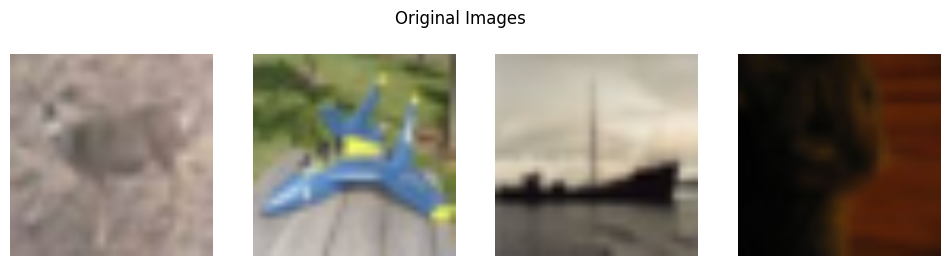

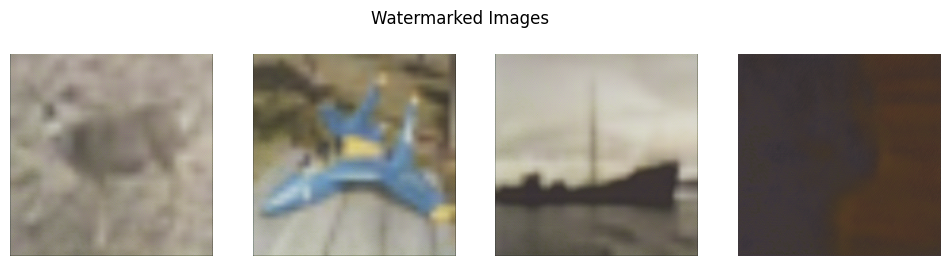

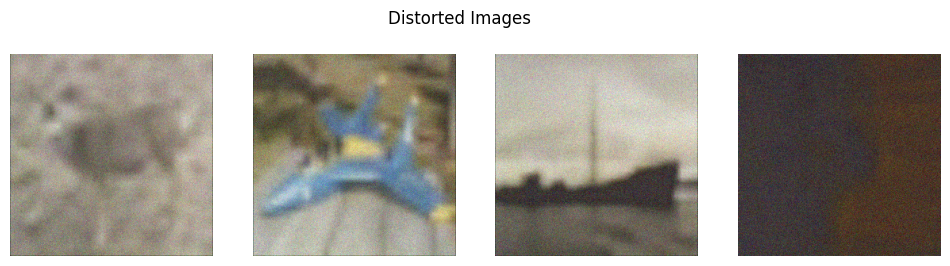

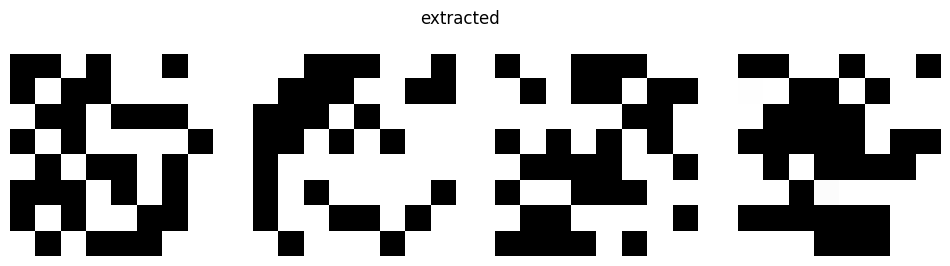

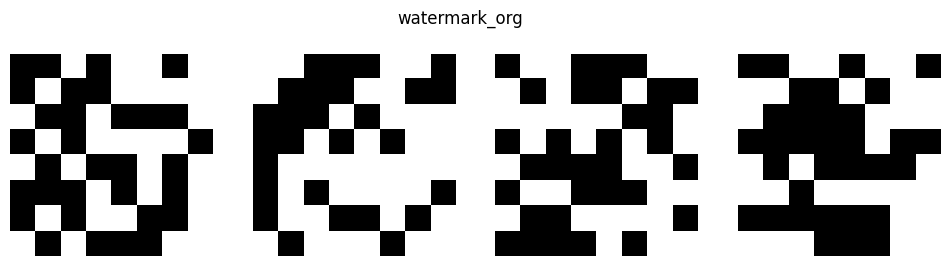

In [5]:
import torch
import matplotlib.pyplot as plt

# Set models to evaluation mode
encoder.eval()
decoder.eval()
saliency.eval()

# Get a batch of test images and watermarks
test_images, test_watermarks = next(iter(dataloader))
test_images = test_images.to(device)
test_watermarks = test_watermarks.to(device)

# Forward pass
with torch.no_grad():
    saliency_maps = saliency(test_images)
    watermarked_images = encoder(test_images, test_watermarks, saliency_maps)
    distorted_images = apply_distortions(watermarked_images)
    extracted_watermarks = decoder(distorted_images)

# Binarize extracted watermarks
binarized_wm = (extracted_watermarks > 0.5).float()

# Calculate accuracy
bitwise_accuracy = (binarized_wm == test_watermarks).float().mean()
print(f"Bitwise Watermark Accuracy: {bitwise_accuracy.item() * 100:.2f}%")

# Visualization
def show_images(images, title, n=4):
    # Check if the input is an image or a watermark
    if len(images.shape) == 4:  # Image (batch, channels, height, width)
        images = images[:n].cpu().permute(0, 2, 3, 1).numpy()
        fig, axes = plt.subplots(1, n, figsize=(n * 3, 3))
        for i in range(n):
            axes[i].imshow(images[i])
            axes[i].axis('off')
        fig.suptitle(title)
        plt.show()
    else:  # Watermark (batch, length)
        # Reshape the watermark into an image-like format for visualization
        # You might need to adjust the dimensions based on your watermark length
        images = images[:n].cpu().view(n, 8, 8).numpy()
        fig, axes = plt.subplots(1, n, figsize=(n * 3, 3))
        for i in range(n):
            axes[i].imshow(images[i], cmap='gray')
            axes[i].axis('off')
        fig.suptitle(title)
        plt.show()

show_images(test_images, "Original Images")
show_images(watermarked_images, "Watermarked Images")
show_images(distorted_images, "Distorted Images")
show_images(extracted_watermarks, "extracted")
show_images(test_watermarks, "watermark_org")